<a href="https://colab.research.google.com/github/pkang0831/Data_Science_Projects/blob/main/WorkSample_InsuranceProductSelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Sample:
Given Instruction:

A consumer bank with a range of products would like to cross-sell insurance to its consumer base (that is, cross-sell the personal protection insurance (PPI) product to those customers who have a secured or unsecured type of loan, but no PPI product as yet).

The bank would like to develop a predictive model to decide who should they target from the pool of customers that currently do not have a PPI.  Please use the sample data in the tab “Data” to develop your model.  The data contains various fields about product ownership, credit standing, outstanding amounts, and whether customers already have an insurance product (called as PPI / personal protection insurance)

Please develop a predictive model.  As a deliverable, please share your code and output for different steps in the model building process.


### Author Name: Paul Kang (Legal Name: Keun Woo Kang)

### Author Email: pkang0831@gmail.com

### Author Contact: +1-416-908-5421

In [ ]:
!pip install --upgrade pandas
!pip install --upgrade xlrd

     |████████████████████████████████| 96 kB 3.5 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


In [ ]:
# Importing basic library
import os
import pandas as pd
import numpy as np
import yaml
import warnings
warnings.filterwarnings("ignore")

#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Common Model Helpers
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

%matplotlib inline

In [ ]:
# Read data
df = pd.read_excel('/Mortgage Insurance Cross Sell - Dataset - Analysis NS D01.xls',sheet_name='Data')

## Model Prototyping Pipeline

In [ ]:
class land(): # or data ingestion stage
    """
    Data ingestion layer where the most basic data quality checks are performed.
    After this class, the work flows to "land2load", "load2model", "model2results", "results2validate"
    """

    # Quick data profiling
    def __init__(self, df):
        self.df = df

    def featureSelect(self):
        """
        Description: 
        From the EDA process, we have observed that some features can be dropped. the are:
        ['Full_Part_Time_Empl_Ind','Perm_Temp_Empl_Ind','Current_Account','Payment_Method','Bankruptcy_Detected__SP_','CIFAS_detected']
        Args:
            - Class self variable
        Output:
            - df: pd.DataFrame == dataframe with dropped variables.
        """
        df = self.df.copy(deep = True)
        df = df.drop(['Ref_ID','Full_Part_Time_Empl_Ind','Perm_Temp_Empl_Ind','Current_Account','Payment_Method','Bankruptcy_Detected__SP_','CIFAS_detected'], axis = 1)
        
        return df

    def dataProfiling(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Description: quick profile overview of data quality
        Args:
            - df: pd.DataFrame == raw data
        Output:
            - data_profiles == profiles that I want to view
        """
        df = self.featureSelect()
        # Check nulls
        _nulls = pd.DataFrame(round(df.isnull().sum()/len(df)*100,2),columns=['null percentage'])
        _dtypes = pd.DataFrame(df.dtypes,columns=['data type'])

        # Duplicated?
        _duplicates = pd.DataFrame([df[i].duplicated().sum() for i in df.columns],columns = ['Duplicate Entries'],index = df.columns)

        # Categorical or Numerical?
        numeric_entries = set(df._get_numeric_data().columns)
        categorical_entries = set(df.columns).difference(numeric_entries)
        _dataform = pd.DataFrame(['Numerical' if i in numeric_entries else 'Categorical' for i in df.columns],columns = ['Num_or_Cat'],index = df.columns)

        # Number of unique values for each variables; max is len(df)
        _unique = pd.DataFrame([len(df[i].unique().tolist()) for i in df.columns], columns = ['Value_counts'],index = df.columns)

        # Concat every info
        data_profiles = pd.concat([_nulls,_dtypes,_duplicates,_dataform,_unique], axis = 1)

        return data_profiles

    def encodeCategoricals(self) -> pd.DataFrame:
        # Run profiling
        df = self.featureSelect()
        df_profile = self.dataProfiling(df)
        col_to_convert = df_profile[df_profile['Num_or_Cat'] == 'Categorical'].index

        def encoders(x, mydict):
            try:
                return mydict[x]
            except:
                return x

        for cols in col_to_convert:
            item_lists = df[cols].unique().tolist()
            item_dict = {idx:i for (i,idx) in zip(range(len(item_lists)),item_lists)}
            df[cols] = df[cols].apply(lambda x: encoders(x,item_dict))
        # update data profilings
        new_df_profile = self.dataProfiling(df)

        return df, df_profile, col_to_convert


In [ ]:
class land2load(land):
    """
    Data processing/feature engineering layer where necessary variable transformation is performed. this step is implemeted after EDA process
    After this class, the work flows to "load2model -- train test splits etc", "model2results", "results2validate"
    """
    def __init__(self,df):
        super().__init__(df)

    def train_test_splits(self, frac = 0.2):
        """
        Description:
        Train-Test datset splitter. since we are not really dealing with time series data, stratification is used
        sklearn library will be used.
        Args:
            - Class self variables
            - frac: float64 == fraction of train/test split, default is 20% split to test data
        Output:
            - returndict: dict == {'x_train','x_test','y_train','y_test'}
                - x_train: pd.DataFrame == train independent variable dataframe
                - y_test: pd.DataFrame == train response variable dataframe
                - x_test: pd.DataFrame == test independent variable dataframe
                - y_test: pd.DataFrame == test response variable dataframe
        """
        df = self.encodeCategoricals()[0]
        
        x_train, x_test, y_train, y_test = model_selection.train_test_split(df.drop('PPI', axis = 1), df['PPI'], test_size = frac, random_state = 42)
        
        return x_train, x_test, y_train, y_test


    def outlierHandlings(self):
        """
        Description:
        Outlier needs to be detected (I will use IQR method for detecting outliers and replace it with median values) - 2 reasons:
        1. Not all numerical variables are following gaussian distribution. so Z-score +-3 method not applicable.
        2. dataset is quite small. dropping them will cause significant loss to the data records.

        Args:
            - None, class self variables
        Output:
            - returndict: dict == {'x_train','x_test','y_train','y_test'}
                - x_train: pd.DataFrame == train independent variable dataframe
                - y_test: pd.DataFrame == train response variable dataframe
                - x_test: pd.DataFrame == test independent variable dataframe
                - y_test: pd.DataFrame == test response variable dataframe
        """
        x_train, x_test, y_train, y_test = self.train_test_splits()

        categoricals = self.encodeCategoricals()[2]

        temp_list = [x_train, x_test]
        for df in temp_list:
            numericals = set(df.columns).difference(set(categoricals))

            for num_cols in numericals:
                iqr = 1.5*(np.percentile(df[num_cols], 75) - np.percentile(df[num_cols], 25))
                median = np.median(df[num_cols])
                df[num_cols] = np.where(df[num_cols] > (iqr + np.percentile(df[num_cols], 75)), median, df[num_cols])
                df[num_cols] = np.where(df[num_cols] < (np.percentile(df[num_cols], 25) - iqr), median, df[num_cols])
                
        return x_train, x_test, y_train, y_test

    def binnings(self):
        # get data
        x_train, x_test, y_train, y_test = self.outlierHandlings()

        df_profile = self.dataProfiling(x_train)

        discrete_cols = list(df_profile[df_profile['Value_counts'] <= 20].index)
        continuous_cols = list(df_profile[df_profile['Value_counts'] > 20].index)
        # Binning
        for col in continuous_cols:
            x_train[col + '_binned'] = pd.cut(x_train[col], 5) # 5 cuts
            x_test[col + '_binned'] = pd.cut(x_test[col], 5)

        binned_col = [i for i in x_train.columns if '_binned' in i]

        x_train_binned = x_train.drop(continuous_cols, axis = 1)
        x_test_binned = x_test.drop(continuous_cols, axis = 1)

        # Label encode those binned objects
        labeler = preprocessing.LabelEncoder()

        for col in x_train_binned:
            x_train_binned[col] = labeler.fit_transform(x_train_binned[col])
        for col in x_test_binned:
            x_test_binned[col] = labeler.fit_transform(x_test_binned[col])

        return x_train_binned, x_test_binned, y_train, y_test
    
    
    def getCorrList(self):
        """
        Description:
        This is a side function that I just made to view the each variable correlations and check whether multicolinearity exists within numerical variables.
        Args:
            - None, class self variables
        Output:
            - corr_df: pd.DataFrame == Pearson R lists
        """
        x_train = self.outlierHandlings()[0]
        y_train = self.outlierHandlings()[2]
        df = pd.concat([x_train,y_train], axis = 1)
        corr_df = pd.DataFrame(df.corr().unstack()).reset_index().rename(columns = {'level_0':'var_1', 'level_1': 'var_2',0:'Pearson R'})
        corr_df = corr_df[corr_df['var_1'] != corr_df['var_2']].dropna().sort_values('Pearson R').drop_duplicates('Pearson R')
        return corr_df
    
    def plotBoxplots(self):
        """
        Description:
        This is a side function that I just made to view boxplots of each variables
        Args:
            - None, class self variables
        Output:
            - Matplotlib.pyplot objects, boxplots
        """
        x_train = self.outlierHandlings()[0]
        y_train = self.outlierHandlings()[2]
        df = pd.concat([x_train,y_train], axis = 1)
        fig,ax = plt.subplots(figsize=(40,120))

        for i,col in enumerate(df.columns):
            plt.subplot(len(df.columns)/4,4,i+1)
            plt.boxplot(x=df[col],showmeans = True, meanline = True)
            x = np.random.normal(1, 0.04, size=len(df[col]))
            plt.plot(x,df[col],'r.',alpha=0.5)
            plt.plot(1,np.mean(df)[i],'bo',alpha=1)
            plt.xlabel(col,fontsize = 20)
    

In [ ]:
class load2model(land2load):
    """
    Data intermediate processing layer where dataframe transformations (train test splits, standardization/normalizations) is performed.
    After this class, the work flows to "model2results", "results2validate"
    """

    def __init__(self, df):
        super().__init__(df)

    def featureScaling(self):
        """
        Description:
        Although for some algorithms, we may not need any standardization/normalization, but for some algorithm that contains any polynomial fittings 
        (algo that contains gradient descent) or process that involves utilization of euclidean distances, we need to standardize them with assuming
        variables follow normal distribution.
        Args:
            - Class self variables
        Outout:
            - returndict: dict == {'x_train_std','x_test_std','y_train','y_test'}
                - x_train: pd.DataFrame == train independent variable dataframe
                - y_test: pd.DataFrame == train response variable dataframe
                - x_test: pd.DataFrame == test independent variable dataframe
                - y_test: pd.DataFrame == test response variable dataframe
        """
        # Call previous pipeline
        x_train, x_test, y_train, y_test = self.outlierHandlings()

        # Initilize stndardization scaler from sklearn.preprocessing
        scaler = preprocessing.StandardScaler()

        # We perform after the splits to avoid any data leakage
        x_train[x_train.columns] = scaler.fit_transform(x_train[x_train.columns])
        x_test[x_test.columns] = scaler.transform(x_test[x_test.columns])

        return x_train, x_test, y_train, y_test


In [ ]:
class model2result(load2model):
    def __init__(self, df):
        super().__init__(df)

    def CrossValidate_Classification(self, select_models = None, scoring = 'f1'):
        """
        Description:
        We train pre-established from scikit-learn, xgboost classifier algorithms to predict the precision, recall and F1 scores. but the thing is,
        we are dealing with "balanced" dataset with approx 60% to 40% 1s and 0s of the PPI so its fairly balanced. in this case, it is okay to use
        Accuracy. I will write both methods... oh and also, there is no need to over/undersample using SMOTE because it is already balanaced..
        Args:
            - Class self variables
            - select_models = **Optional: input the model manually
        Output:
            - model
        """
        x_train, x_test, y_train, y_test = self.featureScaling()
        
        MLA = [
            #Ensemble Methods
            ensemble.AdaBoostClassifier(),
            ensemble.BaggingClassifier(),
            ensemble.ExtraTreesClassifier(),
            ensemble.GradientBoostingClassifier(),
            ensemble.RandomForestClassifier(),

            #Gaussian Processes
            gaussian_process.GaussianProcessClassifier(),
            
            #GLM
            linear_model.LogisticRegressionCV(),
            linear_model.PassiveAggressiveClassifier(),
            linear_model.RidgeClassifierCV(),
            linear_model.SGDClassifier(),
            linear_model.Perceptron(),
            
            #Navies Bayes
            naive_bayes.BernoulliNB(),
            naive_bayes.GaussianNB(),
            
            #Nearest Neighbor
            neighbors.KNeighborsClassifier(),
            
            #SVM
            svm.SVC(probability=True),
            svm.NuSVC(probability=True),
            svm.LinearSVC(),
            
            #Trees    
            tree.DecisionTreeClassifier(),
            tree.ExtraTreeClassifier(),
            
            #Discriminant Analysis
            discriminant_analysis.LinearDiscriminantAnalysis(),
            discriminant_analysis.QuadraticDiscriminantAnalysis(),

            #XGB classifier
            XGBClassifier()  
            ]

        MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Mean', 'MLA Test Mean', 'MLA Test 3*STD' ,'MLA Time']
        MLA_compare = pd.DataFrame(columns = MLA_columns)

        if select_models:
            MLA = select_models

        cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .2, train_size = .8, random_state = 42)

        row_index = 0

        for alg in MLA:

            MLA_name = alg.__class__.__name__
            MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
            MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
            
            cv_results = model_selection.cross_validate(alg, x_train, y_train, return_train_score=True, scoring = scoring, cv = cv_split) # 5 fold 

            MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
            MLA_compare.loc[row_index, 'MLA Train Mean'] = cv_results['train_score'].mean()
            MLA_compare.loc[row_index, 'MLA Test Mean'] = cv_results['test_score'].mean()   

            MLA_compare.loc[row_index, 'MLA Test 3*STD'] = cv_results['test_score'].std()*3   
            
            # alg.fit(x_train, y_train)

            row_index+=1

        MLA_compare.sort_values(by = ['MLA Test Mean'], ascending = False, inplace = True)

        return MLA_compare

    def fitModel(self, default_model = ensemble.GradientBoostingClassifier()):
        x_train, x_test, y_train, y_test = self.featureScaling()
        default_model.fit(x_train,y_train)
        return default_model

    def showFeatureImp(self, selected_model = ensemble.GradientBoostingClassifier()):
        x_train = self.featureScaling()[0]
        y_train = self.featureScaling()[2]
        selected_model.fit(x_train, y_train)
        feat_imp = pd.Series(selected_model.feature_importances_, x_train.columns).sort_values(ascending=False)
        fig, ax = plt.subplots(figsize = (20,10))
        plt.bar(x = feat_imp.index, height = feat_imp.values)
        plt.title('Feature Importance')
        plt.xticks(rotation=90)
        plt.ylabel('Feature Importance Score')
        # return top 20 most import features
        return feat_imp.index[0:20]

    def hypTuning(self, fitted_model, params_grid, scoring = 'f1'):
        """
        Description:
        Selected model: ensemble.GradientBoostingClassifier()
        going to use grid search method
        Args:
            - fitted_model: sklearn model objects
            - params_grid: parameter dictionary for the selected/defaulted model
            - scoring: selected score method
        Output;
            - returndict: name, post tuned performance and tuned parameters
        """
        # get data
        x_train, x_test, y_train, y_test = self.featureScaling()

        x=1

        # use 5 fold cv, max num jobs and f1 scoring scores
        grid = model_selection.GridSearchCV(estimator=fitted_model, param_grid=params_grid, cv=5, n_jobs = -1, scoring = scoring)
        grid_result = grid.fit(x_train, y_train)
        name = fitted_model.__class__.__name__
        post_tuned = grid_result.best_score_
        best_params = str(grid_result.best_params_)
        returndict = {
            'name':name,
            'post_tuned': post_tuned,
            'best_params':best_params
        }
        return returndict


    def validation(self, tuned_model):
        """
        Description:
        model validation with test datasets and calculate the matching ratio
        Args:
            - Class self variables
            - fitted_model; sklearn model objects
            - params: hyperparameters
        Output:
            - result_df: pd.DataFrame
        """
        # Get data
        x_train, x_test, y_train, y_test = self.featureScaling()

        # Fit model with tuned parameters
        model = self.fitModel(tuned_model)

        cross_reports = {}
        auc_scores = {}
        alg_name = []

        pred = pd.DataFrame(model.predict(x_test), columns = [model.__class__.__name__])
        
        model_name = model.__class__.__name__
        cross_report = metrics.classification_report(y_test, pred)
        cross_reports.update({model_name:cross_report})
        auc_score = metrics.roc_auc_score(y_test,pred)
        auc_scores.update({model_name:auc_score})
        print(cross_report)
    
    def confusion_matrix(self, tuned_model):
        # Get data
        x_train, x_test, y_train, y_test = self.featureScaling()

        fig, ax = plt.subplots(figsize=(10,5))
        tuned_model.fit(x_train, y_train)
        metrics.plot_confusion_matrix(tuned_model, x_test, y_test, ax=ax, cmap='Blues',normalize='true',display_labels=[0,1])
        ax.title.set_text(type(tuned_model).__name__)
        plt.tight_layout()  
        plt.show()

    def auc_curves(self, tuned_model):
        # AUC-ROC curves
        # Get data
        x_train, x_test, y_train, y_test = self.featureScaling()

        fig, ax = plt.subplots(figsize=(10,5))
        metrics.plot_roc_curve(tuned_model, x_test, y_test, ax=ax)
        ax.title.set_text(type(tuned_model).__name__)
        plt.tight_layout()  
        plt.show()

## Data Analytics

First, we need to digest what information is available to us.. checking quikcly on what sort of data that i have...

In [ ]:
initializer = model2result(df)
df_profile = initializer.dataProfiling(df)
df_profile

,null percentage,data type,Duplicate Entries,Num_or_Cat,Value_counts
Credit_Score,0.0,int64,15770,Numerical,613
Final_Grade,0.0,object,16373,Categorical,10
Term,0.0,int64,16280,Numerical,103
Net_Advance,0.0,float64,15211,Numerical,1172
APR,0.0,float64,16072,Numerical,311
Loan_Type,0.0,object,16381,Categorical,2
Mosaic,0.0,int64,16320,Numerical,63
Mosaic_Class,0.0,int64,16371,Numerical,12
Time_at_Address,0.0,int64,15857,Numerical,526
Residential_Status,0.0,object,16379,Categorical,4


In [ ]:
# Okay.. no nulls are recorded. thats good
# We do not want to carry variable that are not vary enough (they don't give useful information) lets drop them.
for col in df.columns:
    if len(df[col].value_counts()) < 16300:
        print(df[col].value_counts())

896     147
953     145
1006    137
859     133
893     130
       ... 
352       1
593       1
1264      1
1257      1
562       1
Name: Credit_Score, Length: 613, dtype: int64
A    4538
X    4076
B    2241
C    1538
D    1367
E    1093
F     733
O     341
R     328
S     128
Name: Final_Grade, dtype: int64
60     8428
120    1766
36     1736
48     1492
24      812
       ... 
11        1
95        1
116       1
192       1
67        1
Name: Term, Length: 103, dtype: int64
5000.00     2289
3000.00     1457
10000.00     996
2000.00      866
7500.00      853
            ... 
4646.18        1
6053.00        1
1702.60        1
2730.00        1
8460.00        1
Name: Net_Advance, Length: 1172, dtype: int64
7.9     1383
19.9     990
8.9      950
9.9      899
11.9     689
        ... 
24.3       1
8.3        1
12.0       1
44.2       1
42.1       1
Name: APR, Length: 311, dtype: int64
UnSecured    13054
secured       3329
Name: Loan_Type, dtype: int64
23    1005
44     979
0      901
42    

In [ ]:
# From the output, I can see that ['Full_Part_Time_Empl_Ind','Perm_Temp_Empl_Ind','Current_Account','Payment_Method','Bankruptcy_Detected__SP_','CIFAS_detected']
# can be dropped because most of them are demonstrating approximately 0.5 - 0.6 % variability in binary variable. (change already incorporated in pipeline)

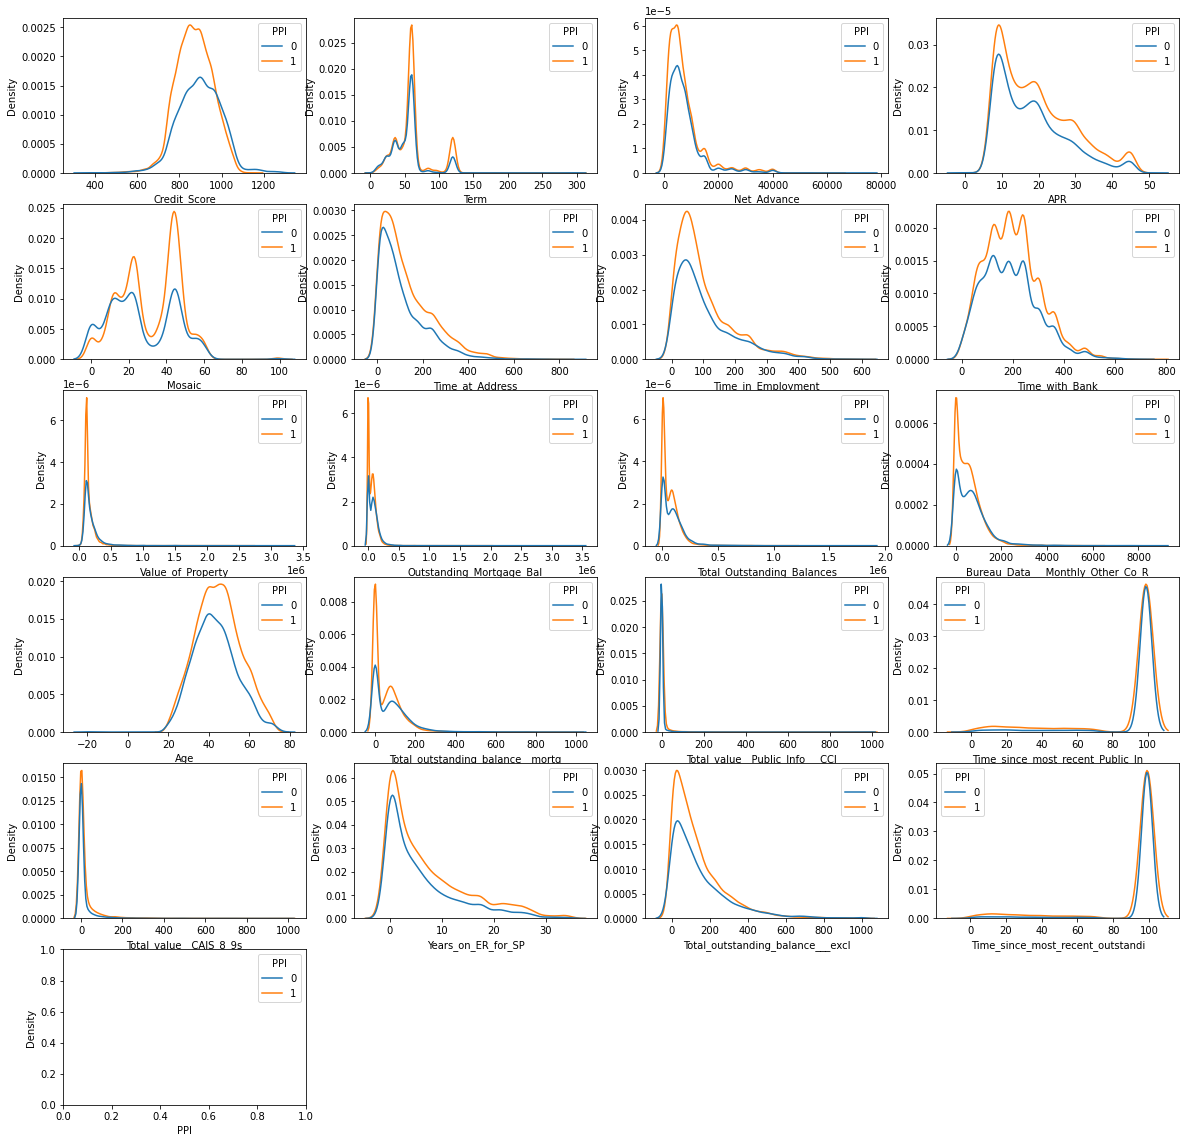

In [ ]:
# Encoding
initializer = model2result(df)
df_profile = initializer.dataProfiling(df)
df_encoded = initializer.encodeCategoricals()[0]
discrete_cols = list(df_profile[df_profile['Value_counts'] <= 20].index)
continuous_cols = list(df_profile[df_profile['Value_counts'] > 20].index)
df_discrete = df_encoded[discrete_cols]
df_continuous = pd.concat([df_encoded[continuous_cols],df_discrete['PPI']], axis = 1)

#Lets handle the outliers in continuous data types. Here, IQR method with replacement of median is acquired (reasons at pipeline function)

for num_cols in continuous_cols:
    iqr = 1.5*(np.percentile(df[num_cols], 75) - np.percentile(df[num_cols], 25))
    median = np.median(df[num_cols])
    df[num_cols] = np.where(df[num_cols] > (iqr + np.percentile(df[num_cols], 75)), median, df[num_cols])
    df[num_cols] = np.where(df[num_cols] < (np.percentile(df[num_cols], 25) - iqr), median, df[num_cols])

# Lets take a peek..
fig, ax = plt.subplots(figsize = (20,20))

for idx, col in enumerate(df_continuous.columns):
    plt.subplot(len(df_continuous.columns)/4 + 1,4,idx+1)
    sns.kdeplot(x = col, hue = 'PPI', data = df_continuous)

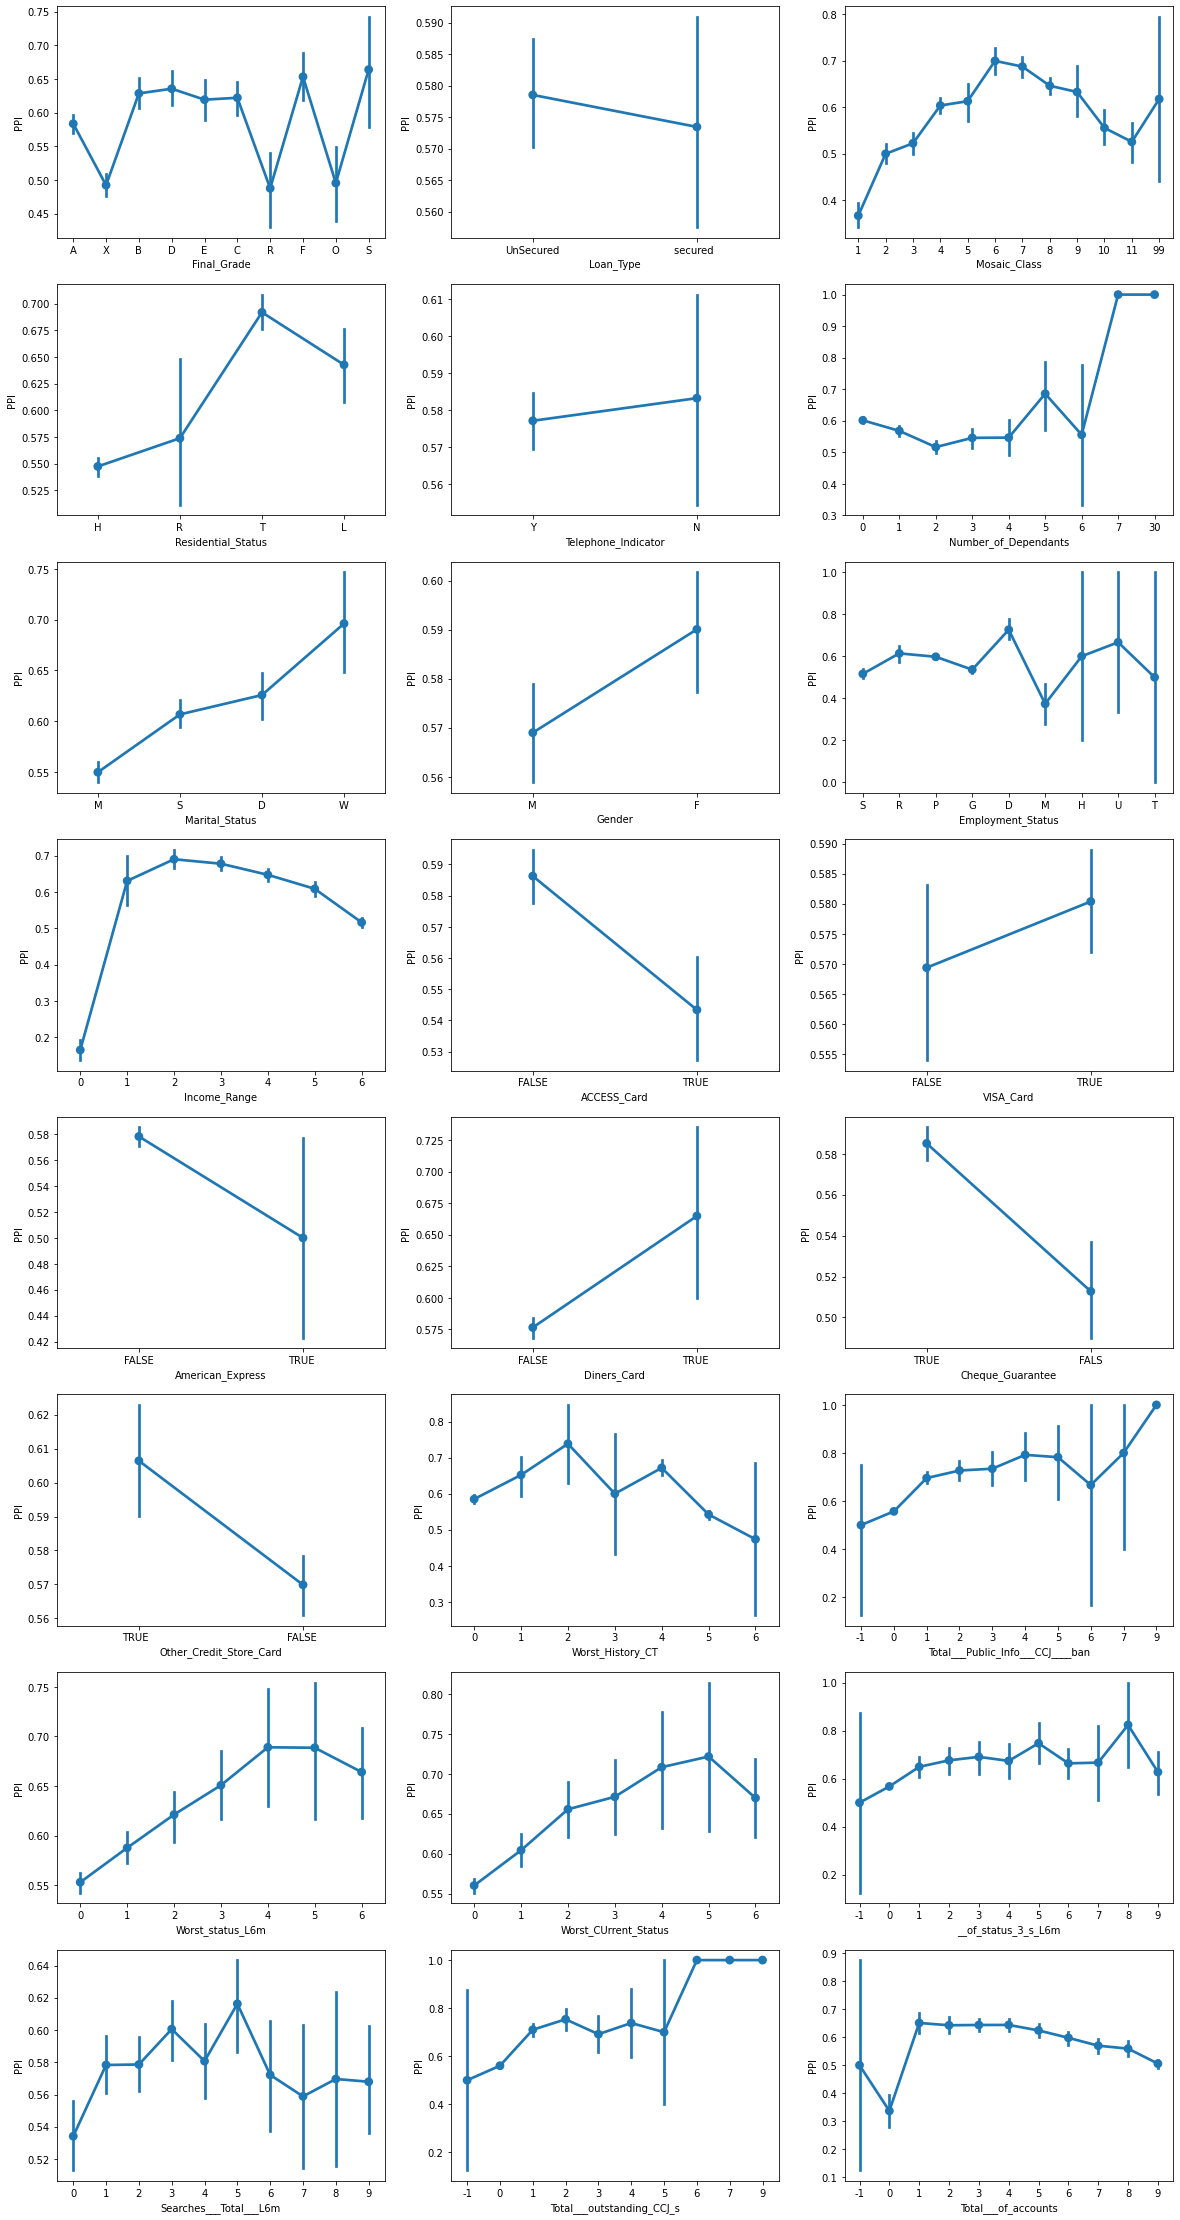

In [ ]:
"""
Okay... so kde plot does not tell me too much info.. let me try to use pointplot (mean of the frequency of the response variable depending on categorical values)
Insights observed from discrete data:
# Question: depending on the person's characteristics, is there any difference in acquiring PPI?
# Finding - for people who has lesser income range, and if they are female, they tend to have PPI
# Finding - people who have lesser number of accounts tend to have PPI... and so on..
# Finding - People who have Residential Status as 'T', 'L' tend to have PPI
# Finding - people who have marital status as 'D', 'W' tend to have PPI
# Finding - people who have higher number of 'Worst Status' or 'Worst Current status' tend to have PPI acquired.
# PPI percentage that is less than 0.6 is meaningless because the PPI sets are almost divided to 0.57 to 0.43 (1 - PPI, 0 - No PPI) respectively
So, it seems people who are financially more vulnerable will tend to have PPI.
"""

fig, saxis = plt.subplots(8, 3,figsize=(20,40))

for idx, col in enumerate(df[discrete_cols[:-1]]):
    y_position = idx % 3
    x_position = int(idx/3)
    sns.pointplot(x = col, y = 'PPI', data = df, ax = saxis[x_position, y_position])


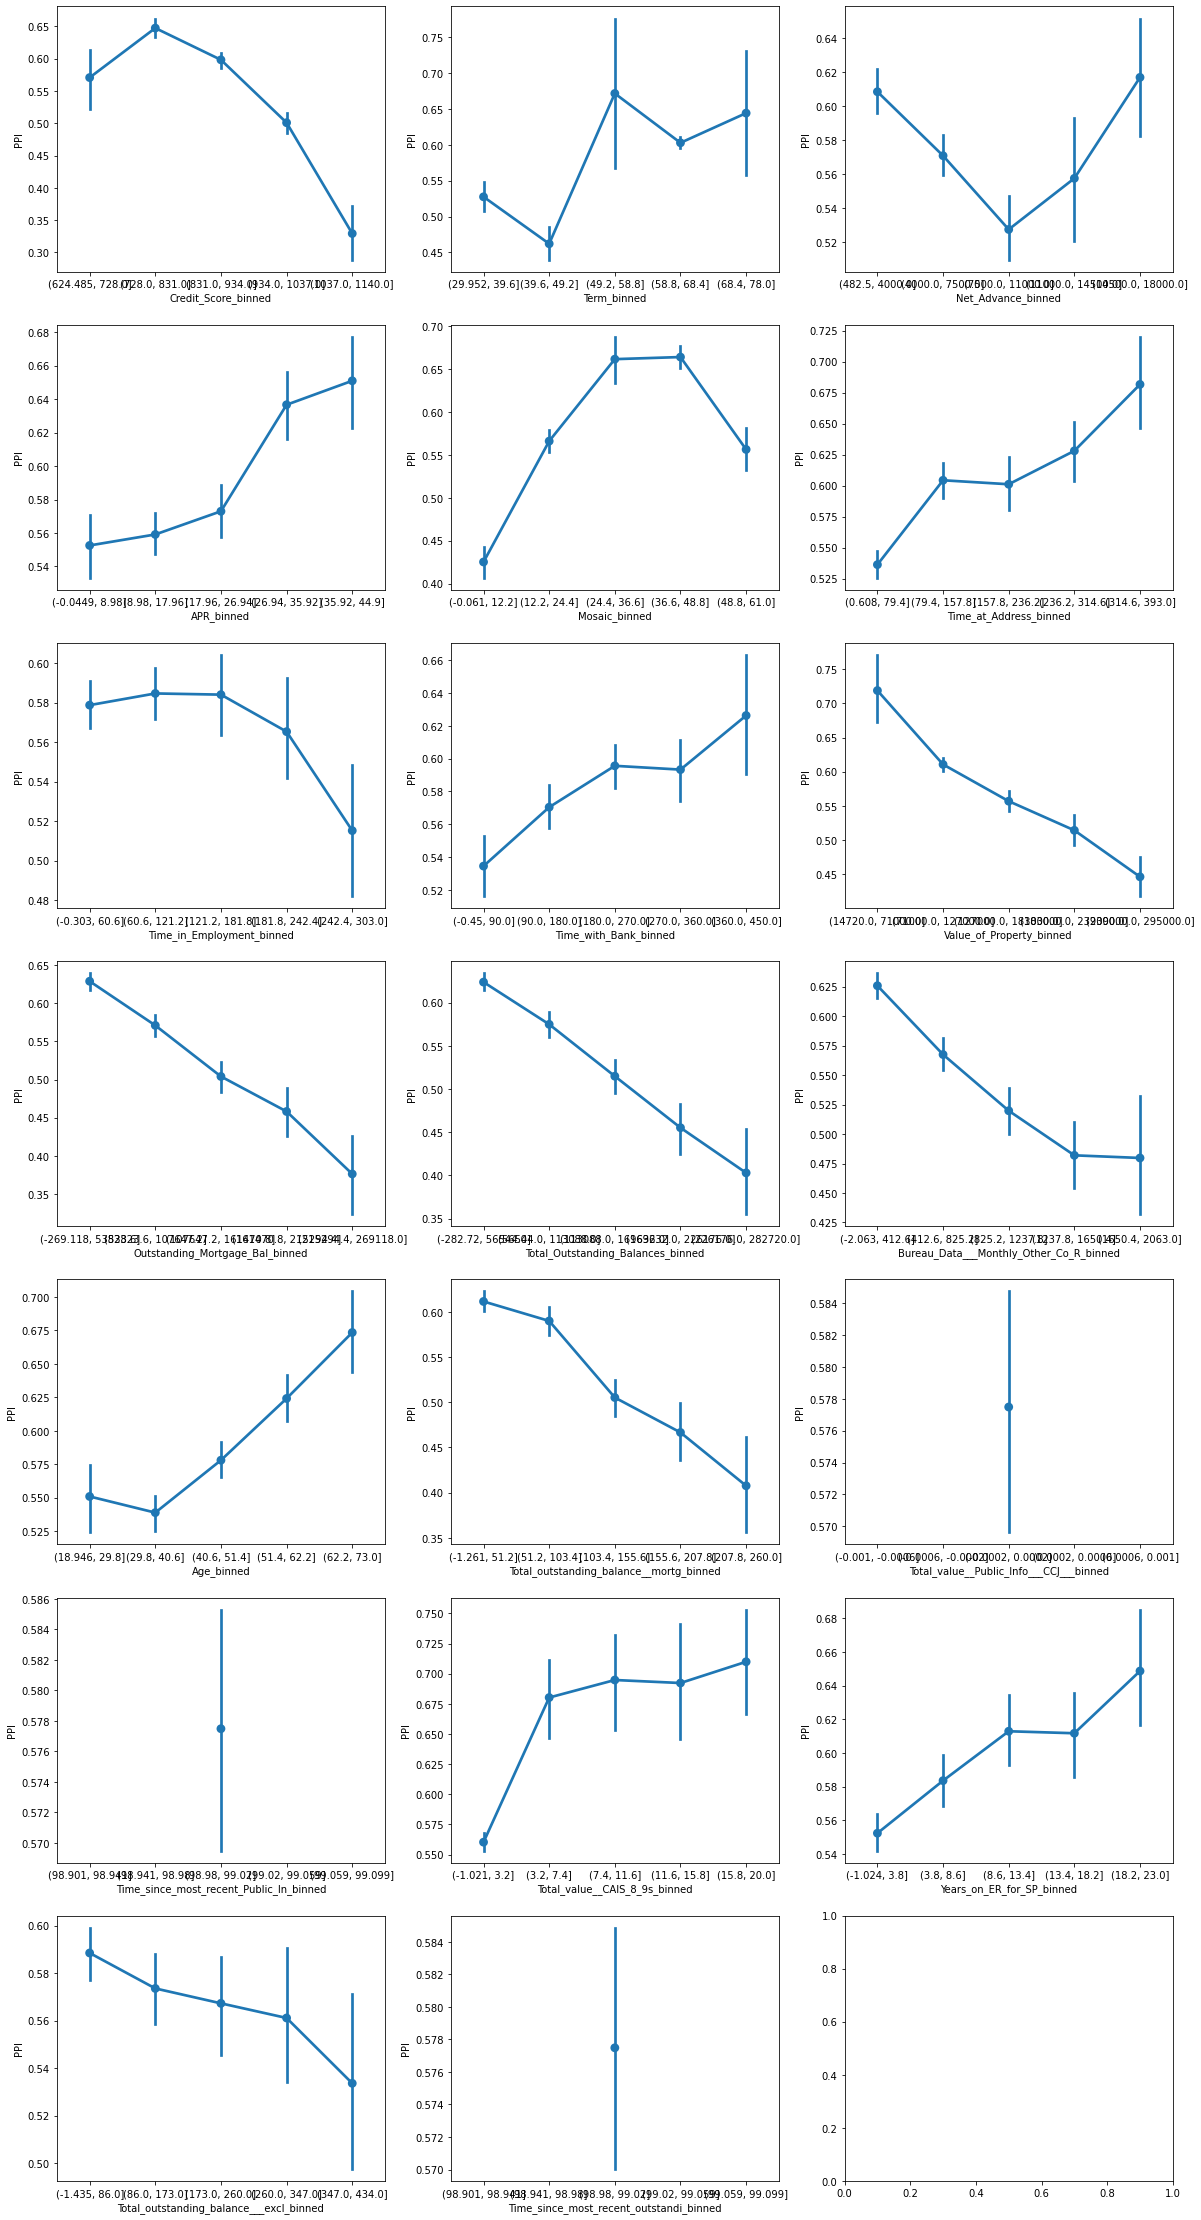

In [ ]:
"""
Insights observed from continuous data:
For continuous types of data, I am going to bin them as needed.
Various insights can be found. Some examples are:
Lower credit score and Higher Age, higher chance that PPI will be acquired
Lower value of property, higher chance that PPI will be acquired.
"""

for col in continuous_cols:
    df[col + '_binned'] = pd.cut(df[col], 5)

binned_col = [i for i in df.columns if '_binned' in i]

fig, saxis = plt.subplots(7, 3,figsize=(20,40))

for idx, col in enumerate(df[binned_col]):
    y_position = idx % 3
    x_position = int(idx/3)
    sns.pointplot(x = col, y = 'PPI', data = df, ax = saxis[x_position, y_position])


In [ ]:
"""
Lets check multicolinearity. Now as stated in my pipeline, it will not really have too much impact on the model 
performance but when the recommendation happesn or any data insights are studied, this can mislead the interpretation.
"""
initializer = model2result(df)
initializer.getCorrList()

,var_1,var_2,Pearson R
1,Credit_Score,Final_Grade,-0.712905
4,Credit_Score,APR,-0.685511
183,APR,Net_Advance,-0.625239
1134,Outstanding_Mortgage_Bal,Residential_Status,-0.564393
1179,Total_Outstanding_Balances,Residential_Status,-0.486489
...,...,...,...
1155,Outstanding_Mortgage_Bal,Total_outstanding_balance__mortg,0.769734
1245,Bureau_Data___Monthly_Other_Co_R,Total_outstanding_balance__mortg,0.788913
1241,Bureau_Data___Monthly_Other_Co_R,Total_Outstanding_Balances,0.830443
1200,Total_Outstanding_Balances,Total_outstanding_balance__mortg,0.951978


## Model Selection, Hyperparameter Tuning

In [ ]:
"""
with the help of the cross validation, lets evaulate each of the pre defined sklearn library and see what is the expected F1 scorings.
Accuracy will do (since this data is fairly balanced), but just to make sure..
so.. it seems that Gradient boosting classifier is the most probable one.

"""
df = pd.read_excel('/Mortgage Insurance Cross Sell - Dataset - Analysis NS D01.xls',sheet_name='Data')
initializer = model2result(df)
################# Do not run this, it is going to take 1 hour.
# initializer.CrossValidate_Classification()

,MLA Name,MLA Parameters,MLA Train Mean,MLA Test Mean,MLA Test 3*STD,MLA Time
21,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.770739,0.748869,0.029144,1.430248
3,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.772731,0.747595,0.030597,4.065011
14,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.803655,0.744425,0.029499,52.466746
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.746022,0.741384,0.024009,1.014863
4,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",1.0,0.737664,0.030757,2.556905
2,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",1.0,0.737427,0.037879,1.728701
8,RidgeClassifierCV,"{'alphas': array([ 0.1, 1. , 10. ]), 'class_w...",0.730954,0.731373,0.029745,0.099909
16,LinearSVC,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.730894,0.731287,0.028015,2.754072
19,LinearDiscriminantAnalysis,"{'covariance_estimator': None, 'n_components':...",0.730439,0.731216,0.029805,0.167459
6,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.730028,0.730704,0.029825,1.517507


In [ ]:
"""
Lets fit the model and go through hyperparameter tuning
It turns out that the hyperparameter tuning is returning worse result than the default setting of a model.
"""
selected_models = {
    'GBM': ensemble.GradientBoostingClassifier()
}
fitted_model = initializer.fitModel(selected_models['GBM'])
params_grid = {
    'learning_rate':[0.01, 0.05, 0.1],  
    'min_samples_split':[2, 5, 10, 20], 
    'max_depth':[2, 5, 10]
}
# best parameter found
params_results = initializer.hypTuning(fitted_model=fitted_model, params_grid=params_grid)

best_params = yaml.load(params_results['best_params'])
print(f"best parameter for {fitted_model.__class__.__name__} : {best_params}")
tuned_model = ensemble.GradientBoostingClassifier(**best_params)

for model_names, model in selected_models.items():
    print(model_names, ", no tuned")
    initializer.validation(tuned_model=model)
print(fitted_model.__class__.__name__, ", tuned")
initializer.validation(tuned_model=tuned_model)

best parameter for GradientBoostingClassifier : {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_split': 5}
GBM , no tuned
              precision    recall  f1-score   support

           0       0.66      0.46      0.54      1438
           1       0.66      0.81      0.73      1839

    accuracy                           0.66      3277
   macro avg       0.66      0.63      0.63      3277
weighted avg       0.66      0.66      0.64      3277

GradientBoostingClassifier , tuned
              precision    recall  f1-score   support

           0       0.71      0.26      0.38      1438
           1       0.61      0.92      0.73      1839

    accuracy                           0.63      3277
   macro avg       0.66      0.59      0.56      3277
weighted avg       0.66      0.63      0.58      3277



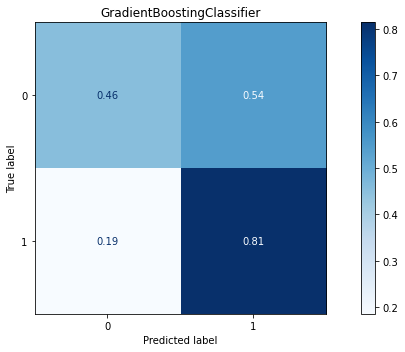

In [ ]:
"""
Lets plot the confusion matrix
"""
initializer.confusion_matrix(selected_models['GBM'])

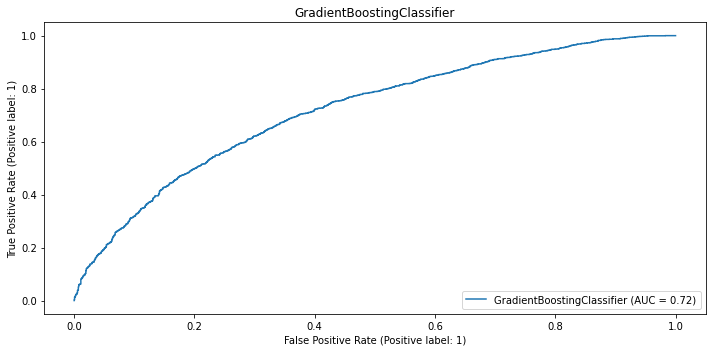

In [ ]:
"""
Lets plot the area under curve
"""
initializer.auc_curves(selected_models['GBM'])

## Conclusion
So.. overall the model is selected, hyperparameter is tuned with the best test scores of 0.66 of f1 weighted average. now, this is slightly better than "flip-the-coin" model (50% accuracy) or "predict everything to 1" (57.7%) accuracy of target class 1... We need better predictor / better feature engineering that will better perform... and remember, this is a tree based algorithm, so it may not fully perform the way we wanted to.

Problem framed as Classification for this task may not be fully correct, as we are interested in capturing the probability / likelihood of customer acquring PPI or not. for that, we can calculate the probability of each customer.

Furthermore, this model tends to have high False Positive and minimize False Negatives where it tends to make recommendation to customer who does not need to have PPI. This eventually leads to a one sided perspective which is an almost win-win situation for customer and the bank, where customer gain security and bank gains profit as they can cross sell their PPI product.

With the test weighted F1 score of 0.66 may seem not so good, It is fortunate out of unfortunates that we are able to minimize the False negatives where customer who actually needs PPI and bank avoids to sell PPI to those customer.

Thank you for this task. I really enjoyed it

# APPENDIX - DO NOT REFER

In [ ]:

## Deep Learning quick try outs - do not refer
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
# get data
dataframe = pd.read_excel('/Mortgage Insurance Cross Sell - Dataset - Analysis NS D01.xls',sheet_name='Data')
initializer = model2result(dataframe)
x_train, x_test, y_train, y_test = initializer.outlierHandlings()
x_train_set = x_train.values.astype('float32')
x_test_set = x_test.values.astype('float32')
y_train_set = y_train.values.astype('float32')
y_test_set = y_test.values.astype('float32')

# mlp for binary classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

n_features = x_train_set.shape[1]

model = Sequential()
model.add(Dense(20, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(x_train_set, y_train_set, epochs=150, batch_size=32, verbose=0)

loss, acc = model.evaluate(x_test_set, y_test_set, verbose=0)
print('Test Accuracy: %.3f' % acc)

## PCA fittings - As a reference

Text(0, 0.5, 'Cumulative Explained Variance')

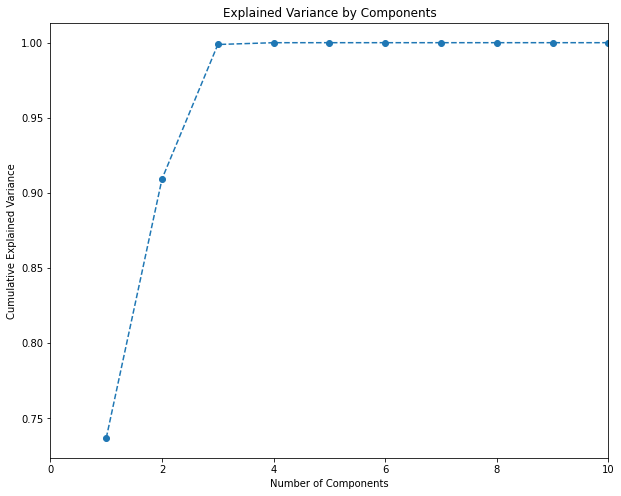

In [ ]:
Init = model2result(df)
df_processed = Init.encodeCategoricals()[0]
categoricals = Init.encodeCategoricals()[2]
numericals = set(df_processed.columns).difference(set(categoricals))

for num_cols in numericals:
    iqr = 1.5*(np.percentile(df_processed[num_cols], 75) - np.percentile(df_processed[num_cols], 25))
    median = np.median(df_processed[num_cols])
    df_processed[num_cols] = np.where(df_processed[num_cols] > (iqr + np.percentile(df_processed[num_cols], 75)), median, df_processed[num_cols])
    df_processed[num_cols] = np.where(df_processed[num_cols] < (np.percentile(df_processed[num_cols], 25) - iqr), median, df_processed[num_cols])

# PCA fitting

scaler = preprocessing.StandardScaler()
segmentation_std = scaler.fit_transform(df_processed)
pca = PCA()
pca.fit(df_processed)

plt.figure(figsize=(10,8))
plt.plot(range(1,52) , pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.xlim([0,10])
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

Text(0, 0.5, 'WCSS')

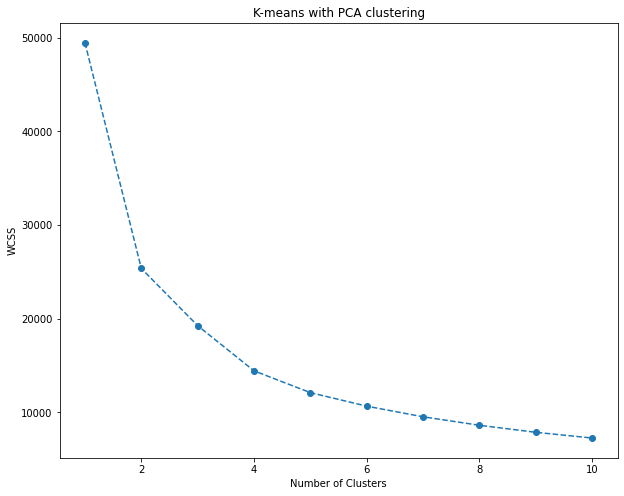

In [ ]:
pca = PCA(n_components=3)
pca.fit(df_processed)
pca.transform(segmentation_std)
scores_pca = pca.transform(segmentation_std)
# pd.DataFrame(pca.components_,columns=df_processed.drop(['PPI'], axis = 1).columns)
wcss = []
for i in range(1,11):
    kmeans_pca = KMeans(n_clusters=i,init='k-means++',random_state=42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

plt.figure(figsize=(10,8))
plt.plot(range(1,11) , wcss, marker = 'o', linestyle = '--')
plt.title('K-means with PCA clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')

In [ ]:
kmeans_pca = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans_pca.fit(scores_pca)
df_with_pca_cluster = pd.concat([df_processed.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)
df_with_pca_cluster.columns.values[-3:] = ['PC_1','PC_2','PC_3']
df_with_pca_cluster['K Means Cluster #'] = kmeans_pca.labels_
df_with_pca_cluster.head()

,Credit_Score,Final_Grade,Term,Net_Advance,APR,Loan_Type,Mosaic,Mosaic_Class,Time_at_Address,Residential_Status,...,Total___outstanding_CCJ_s,Total_outstanding_balance___excl,Total___of_accounts,CIFAS_detected,Time_since_most_recent_outstandi,PPI,PC_1,PC_2,PC_3,K Means Cluster #
0,918.0,0,36.0,3000.0,14.4,0,46.0,8.0,132.0,0,...,0.0,18.0,6.0,0,99.0,0.0,-134127.095644,103793.209954,-23553.166934,0
1,903.0,0,60.0,5300.0,7.9,1,16.0,3.0,288.0,0,...,0.0,203.0,8.0,0,99.0,1.0,-134127.810654,103792.959042,-23553.012167,0
2,1060.0,1,78.0,7200.0,7.9,1,17.0,3.0,276.0,0,...,0.0,87.0,7.0,0,99.0,1.0,-134127.678019,103792.563741,-23553.056821,0
3,839.0,2,60.0,8000.0,16.9,0,47.0,8.0,48.0,1,...,0.0,229.0,9.0,0,99.0,1.0,-134126.711802,103794.965473,-23551.737236,3
4,1057.0,1,60.0,7650.0,7.4,0,55.0,10.0,156.0,0,...,0.0,38.0,6.0,0,99.0,1.0,-134126.946276,103793.175152,-23553.324627,0


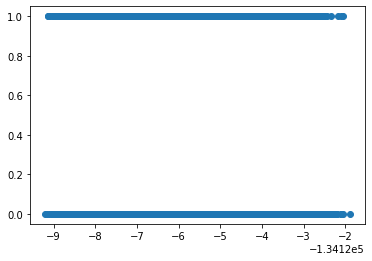

In [ ]:
plt.scatter(df_with_pca_cluster['PC_1'],df_with_pca_cluster['PPI'])

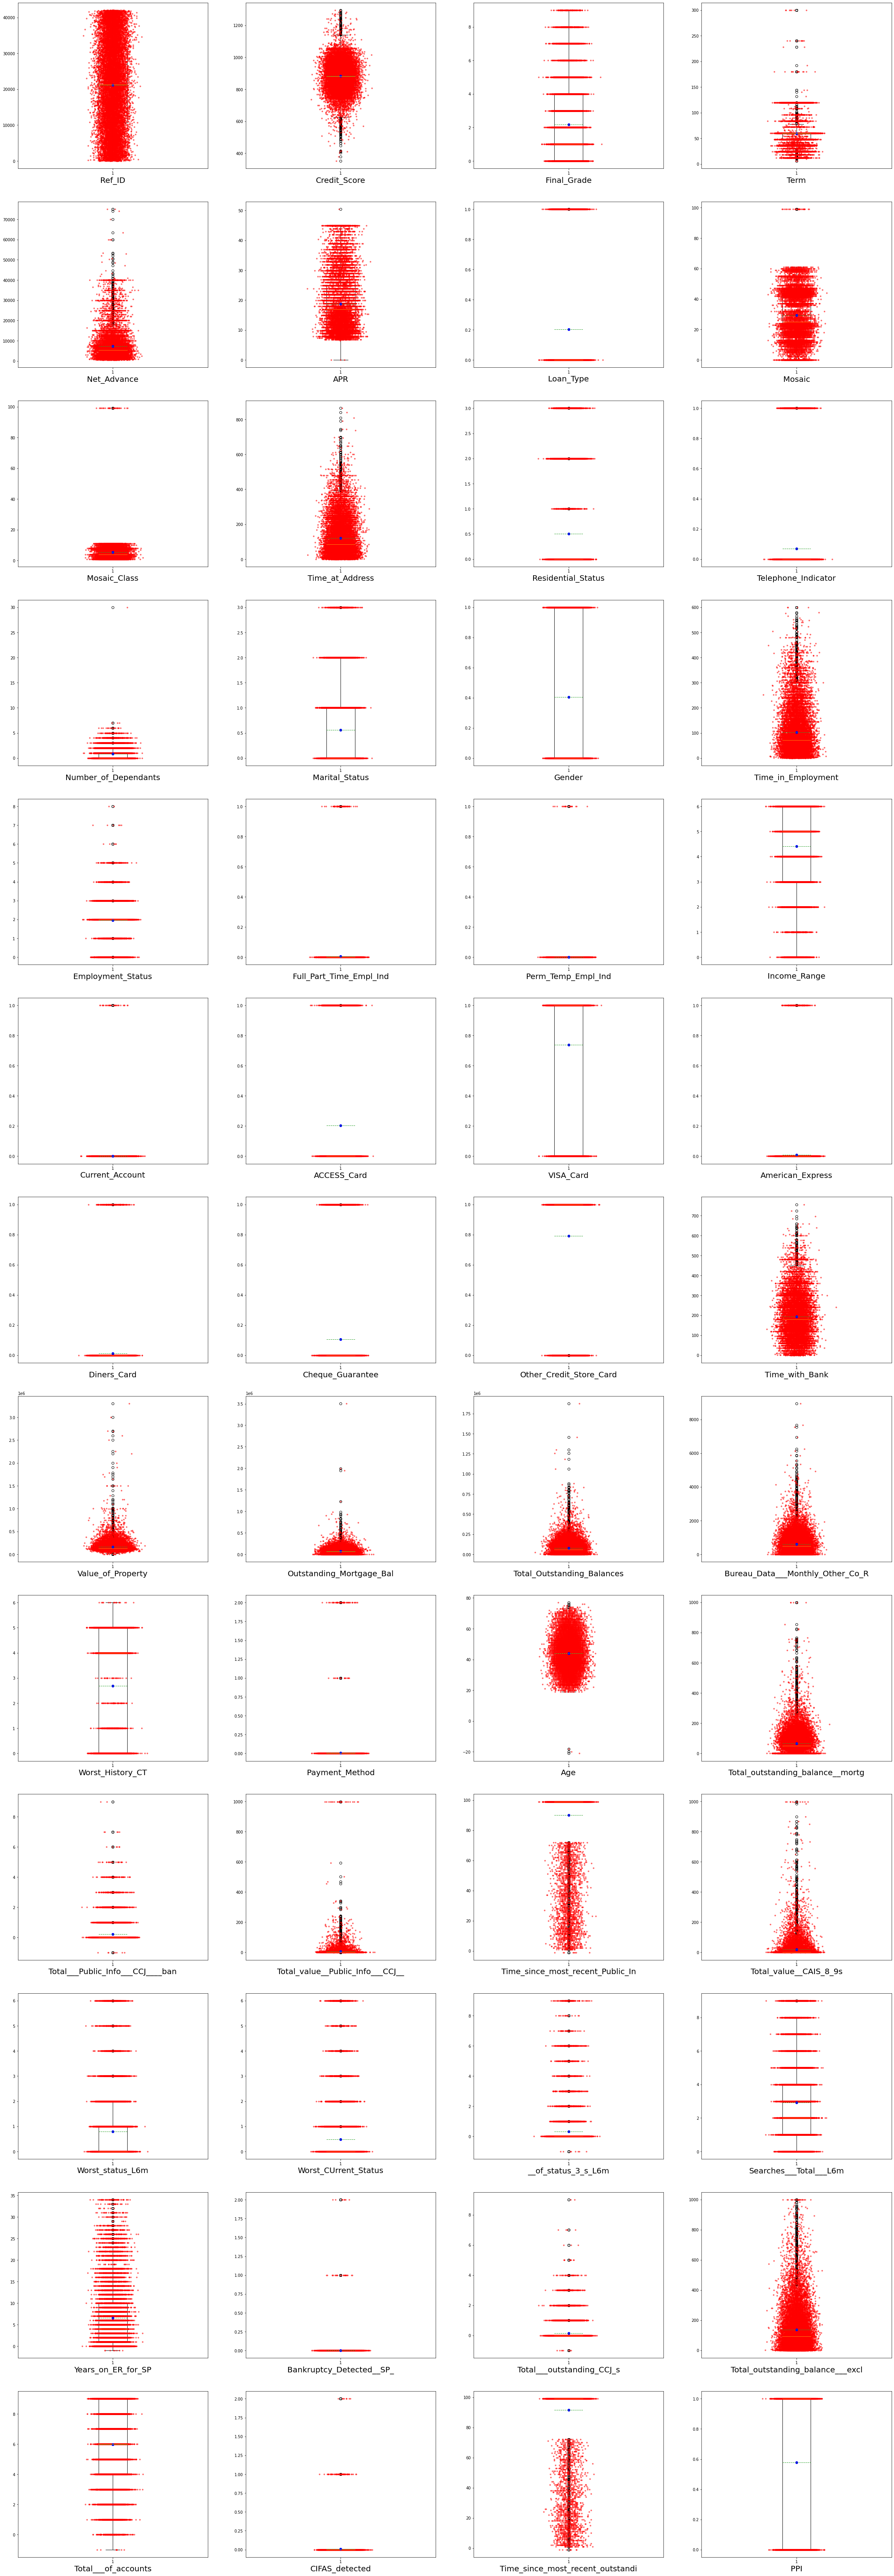

In [ ]:
## Intermediate EDA
Init = land(df)
df = Init.encodeCategoricals()[0]
df_profile = Init.encodeCategoricals()[1]

# Data outlier checks (boxplots):

fig,ax = plt.subplots(figsize=(40,120))

for i,col in enumerate(df.columns):
  plt.subplot(len(df.columns)/4,4,i+1)
  plt.boxplot(x=df[col],showmeans = True, meanline = True)
  x = np.random.normal(1, 0.04, size=len(df[col]))
  plt.plot(x,df[col],'r.',alpha=0.5)
  plt.plot(1,np.mean(df)[i],'bo',alpha=1)
  plt.xlabel(col,fontsize = 20)

# For the numerical variables, it is common to remove/impute outliers so as to make sure that those outliers does not skew the resulting model's
# parameter too much

In [ ]:
# Outlier needs to be detected (I will use IQR method for detecting outliers and replace it with median values) - 2 reasons:
# 1. Not all numerical variables are following gaussian distribution. so Z-score +-3 method not applicable.
# 2. dataset is quite small. dropping them will cause significant loss to the data records.

categoricals = Init.encode_categoricals()[2]
numericals = set(df.columns).difference(set(categoricals))

for num_cols in numericals:
    iqr = 1.5*(np.percentile(df[num_cols], 75) - np.percentile(df[num_cols], 25))
    median = np.median(df[num_cols])
    df[num_cols] = np.where(df[num_cols] > (iqr + np.percentile(df[num_cols], 75)), median, df[num_cols])
    df[num_cols] = np.where(df[num_cols] < (np.percentile(df[num_cols], 25) - iqr), median, df[num_cols])


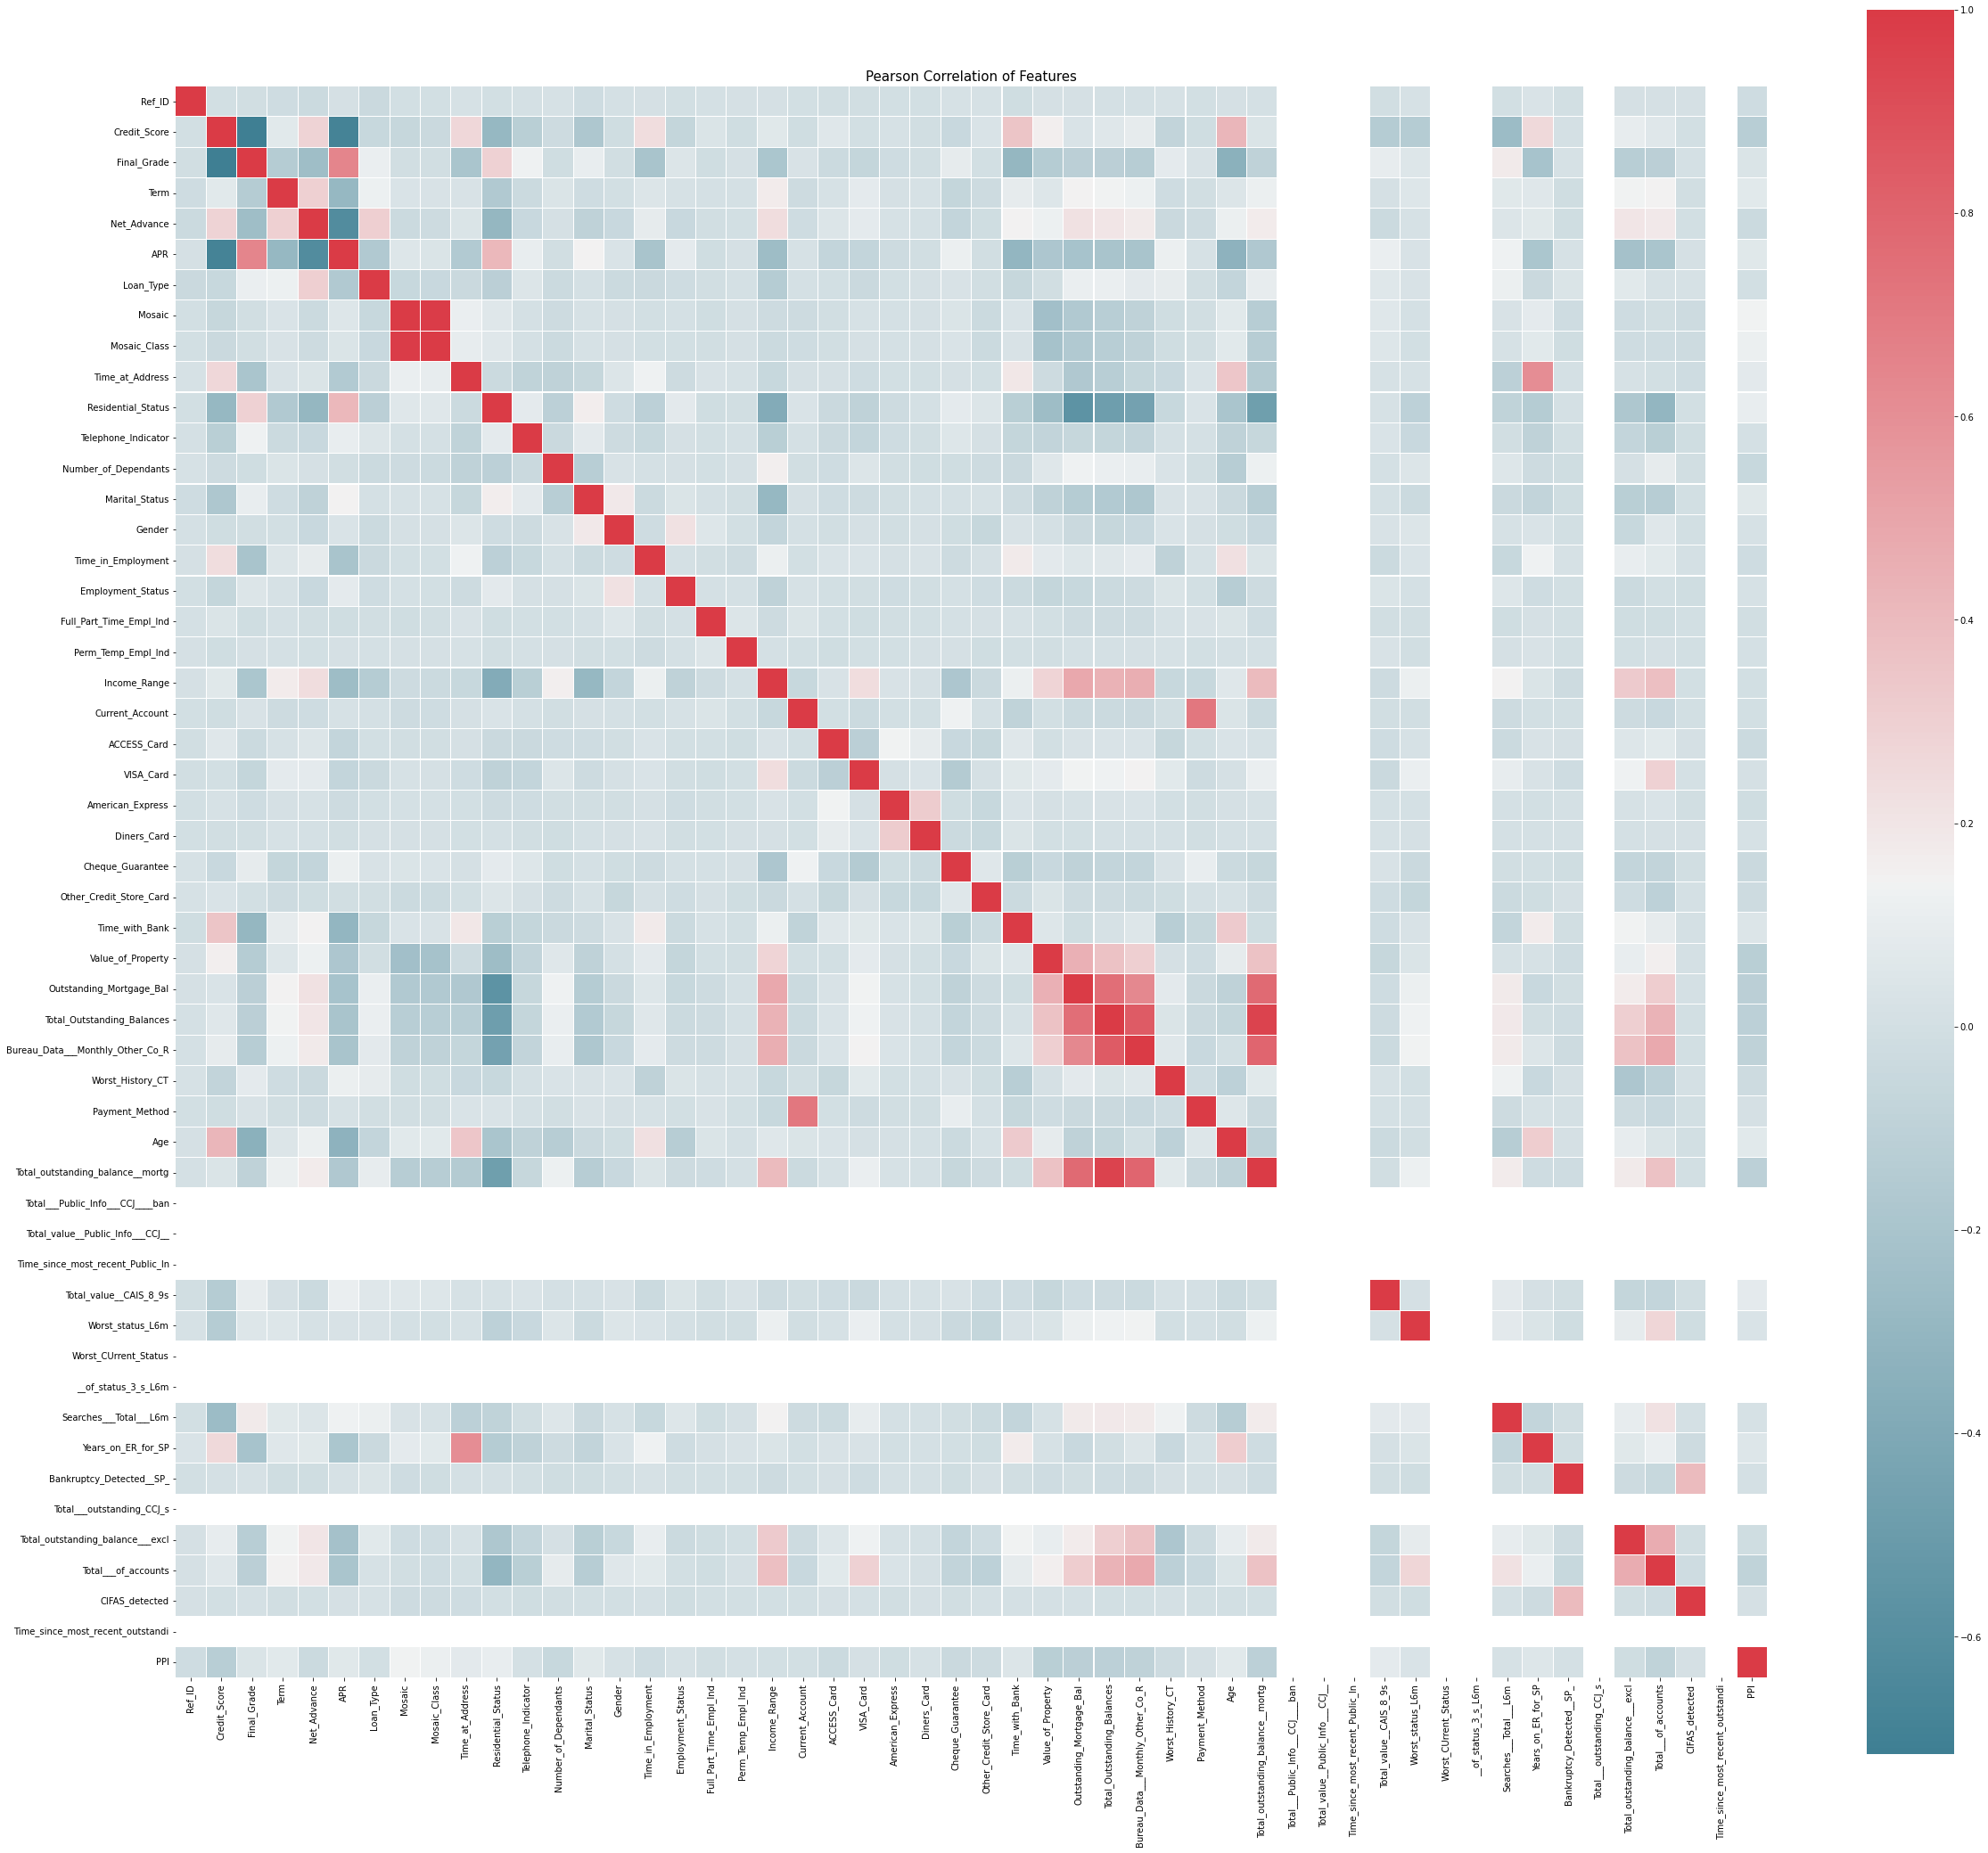

In [ ]:
# correlation matrix - identify confounding matrix
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(40, 40))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=False, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':8 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(df)
# Well.. this does not tell me much. let me bring up some more elegant approach...

In [ ]:
corr_df = pd.DataFrame(df.corr().unstack()).reset_index().rename(columns = {'level_0':'var_1', 'level_1': 'var_2',0:'Pearson R'})
corr_df = corr_df[corr_df['var_1'] != corr_df['var_2']].dropna().sort_values('Pearson R').drop_duplicates('Pearson R')
corr_df
# So some of the variables here have colinearity happening: it does not impact directly in terms of the accuracy of the model, 
# but the interpretation on making recommendation out from this model can be misleading. There are two options for how to handle
# this particular issue; drop one of the variable that shares high multi colinearity with other variables, or just keep them - handle it after model 
# spits out a number but be carefule of how you interpret the results later...


,var_1,var_2,Pearson R
105,Final_Grade,Credit_Score,-0.715308
57,Credit_Score,APR,-0.684418
264,APR,Net_Advance,-0.616984
549,Residential_Status,Outstanding_Mortgage_Bal,-0.562873
1570,Total_Outstanding_Balances,Residential_Status,-0.482114
...,...,...,...
1849,Total_outstanding_balance__mortg,Outstanding_Mortgage_Bal,0.776271
1647,Bureau_Data___Monthly_Other_Co_R,Total_outstanding_balance__mortg,0.797850
1642,Bureau_Data___Monthly_Other_Co_R,Total_Outstanding_Balances,0.839895
1850,Total_outstanding_balance__mortg,Total_Outstanding_Balances,0.956068
